In [10]:
import os
import numpy as np
from scipy.fftpack import dct
from scipy.signal import cwt
from pywt import dwt2
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from IPython import display

from utils import (
    SoftThresh,
    ShrinkageOperator,
    Proj
)

%matplotlib inline

## Import an image to compress and reconstruct

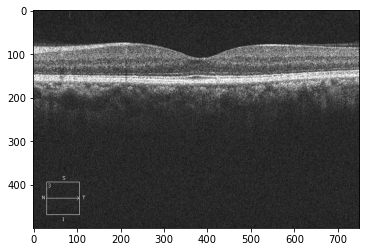

In [11]:
image_path = "OCTID_NORMAL"
image_name = "NORMAL10.jpeg"
image = os.path.join(image_path, image_name)

oct_image = imread(image)
plt.imshow(oct_image, cmap='gray')

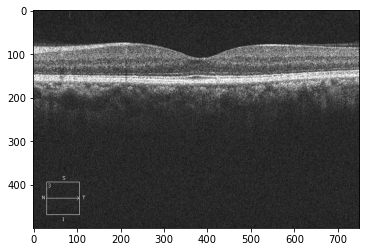

In [12]:
# Taking the first of the 3 channels, as they are all the same.
X = oct_image[:,:,0]
plt.imshow(oct_image, cmap='gray')

## Create a random mask (this is our projection operator $\mathcal{P}_{\Omega}$)

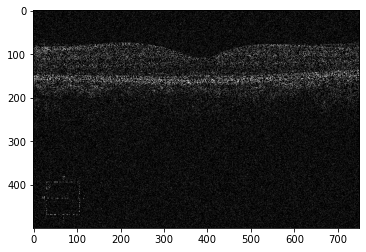

In [229]:
compression_factor = 3
h, w = X.shape
mask = np.random.binomial(size=(h, w), n=1, p=1/compression_factor)
D = X*mask
plt.imshow(X*mask, cmap="gray")

# Set up our initial variables for the $\ell_{1}$ norm minimization problem

W is the variable that we are trying to optimize with repect to. W is used as the weights for our chosen basis vectors, and we seek to enforce that $\mathcal{P}_{\Omega}(B_{1} W B_{2}^{\mathbf{T}}) \approx \mathcal{P}_{\Omega}(X)$, and that we have either $\text{rank}(W) \leq k$m for some small value of $k$, or that $\lVert W \rVert_{0}$ is small, or both. (We want matrix $W$ to be sparse/lowrank). 

### set basis = 'dct' to use discrete cosine basis or to "wavelet" to use a wavelet basis.

In [230]:
basis_ = "dct"

if basis_ == "dct":
    B1 = dct(np.eye(h), norm='ortho', axis=0).T
    B2t = dct(np.eye(w), norm='ortho', axis=0)
else: 
    # pywt.dwt2 is the discrete wavelet transform in 2D. It returns the transformed array
    # in 4 equaly sized block matrices which are simplpy regions of the entire 2D transform
    (cA, (cH, cV, cD)) = dwt2(np.eye(h), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B1 = np.concatenate([upper, lower], axis=1)
    
    (cA, (cH, cV, cD)) = dwt2(np.eye(w), 'db1')
    upper = np.concatenate([cA, cH])
    lower = np.concatenate([cV, cD])
    B2t = np.concatenate([upper, lower], axis=1)

D = X*mask
W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

tau = 1
a = 1

# range of hyperparameters to weight the reconstruction loss against the sparsity loss
lbda_search_space = np.concatenate([[0.1, 0.3], np.arange(0.5, 15, 0.25)])

In [227]:
def Update1(mask, B1, B2t, W, D, a):
    # Minimize the error with respect to constraint P_{\Omega}(B1 @ W @ B2t) == P_{\Omega}
    Z = Proj(B1 @ W @ B2t, mask) - D
    Z = B1.T @ Z @ B2t.T
    return W - a*Z

## Hyperparameter search for optimal balance between reconstruction and sparsity.

In [280]:
min([min(results[l]['reconstruction']) for l in results.keys()])

7475.720108334109

In [203]:
lbda_search_space = np.concatenate([[0.1, 0.3], np.arange(0.5, 6, 0.5)])
iters = 1000

for lbda in np.arange(50, 75, 1):
    print(f"Starting Optimizer with lambda={lbda}")
    reconstruction_error = []
    spectral_norm = []
    sparsity = []
    
    # reset the initial W 
    W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)    
    for i in range(iters):
        W = Update1(mask, B1, B2t, W, D, a)
        W = ShrinkageOperator(W, lbda*tau)

        spectral_norm.append(np.linalg.norm(W, ord="nuc"))
        sparsity.append(np.linalg.norm(W, ord=1))
        reconstruction_error.append(np.linalg.norm(X - B1 @ W @ B2t))
        if i % 50 == 0:
            print(
                f"\tIteration {i+1}:\t"\
                f"Reconstruction Error: {reconstruction_error[-1]:.2f}\t"\
                f"Spectral Norm W: {spectral_norm[-1]:.2f}\t"\
                f"Sparisty of W: {sparsity[-1]:.2f}"
            )
            
    results[lbda] = {
        'spectral': spectral_norm,
        'sparsity': sparsity,
        'reconstruction': reconstruction_error,
        'W': W
    }

Starting Optimizer with lambda=50
	Iteration 1:	Reconstruction Error: 31813.35	Spectral Norm W: 410277.50	Sparisty of W: 84441.93
	Iteration 51:	Reconstruction Error: 15742.17	Spectral Norm W: 189352.66	Sparisty of W: 109840.42
	Iteration 101:	Reconstruction Error: 9554.92	Spectral Norm W: 157016.30	Sparisty of W: 135701.49
	Iteration 151:	Reconstruction Error: 7866.47	Spectral Norm W: 151174.33	Sparisty of W: 149179.63
	Iteration 201:	Reconstruction Error: 7568.63	Spectral Norm W: 150536.09	Sparisty of W: 153697.03
	Iteration 251:	Reconstruction Error: 7510.22	Spectral Norm W: 150479.42	Sparisty of W: 154925.92
	Iteration 301:	Reconstruction Error: 7495.62	Spectral Norm W: 150473.72	Sparisty of W: 155284.44
	Iteration 351:	Reconstruction Error: 7491.44	Spectral Norm W: 150473.07	Sparisty of W: 155396.53
	Iteration 401:	Reconstruction Error: 7490.18	Spectral Norm W: 150472.99	Sparisty of W: 155433.62
	Iteration 451:	Reconstruction Error: 7489.78	Spectral Norm W: 150472.98	Sparisty of W

	Iteration 101:	Reconstruction Error: 9077.41	Spectral Norm W: 153716.38	Sparisty of W: 138721.85
	Iteration 151:	Reconstruction Error: 7746.04	Spectral Norm W: 149389.33	Sparisty of W: 150834.98
	Iteration 201:	Reconstruction Error: 7545.14	Spectral Norm W: 149031.99	Sparisty of W: 154260.28
	Iteration 251:	Reconstruction Error: 7507.53	Spectral Norm W: 149005.42	Sparisty of W: 155107.26
	Iteration 301:	Reconstruction Error: 7498.58	Spectral Norm W: 149003.10	Sparisty of W: 155337.62
	Iteration 351:	Reconstruction Error: 7496.18	Spectral Norm W: 149002.87	Sparisty of W: 155404.98
	Iteration 401:	Reconstruction Error: 7495.52	Spectral Norm W: 149002.84	Sparisty of W: 155425.91
	Iteration 451:	Reconstruction Error: 7495.33	Spectral Norm W: 149002.84	Sparisty of W: 155432.77
	Iteration 501:	Reconstruction Error: 7495.28	Spectral Norm W: 149002.84	Sparisty of W: 155435.12
	Iteration 551:	Reconstruction Error: 7495.26	Spectral Norm W: 149002.84	Sparisty of W: 155435.97
	Iteration 601:	Reco

	Iteration 251:	Reconstruction Error: 7509.11	Spectral Norm W: 147553.52	Sparisty of W: 155212.05
	Iteration 301:	Reconstruction Error: 7503.57	Spectral Norm W: 147552.60	Sparisty of W: 155360.40
	Iteration 351:	Reconstruction Error: 7502.20	Spectral Norm W: 147552.52	Sparisty of W: 155401.04
	Iteration 401:	Reconstruction Error: 7501.86	Spectral Norm W: 147552.52	Sparisty of W: 155412.92
	Iteration 451:	Reconstruction Error: 7501.77	Spectral Norm W: 147552.51	Sparisty of W: 155416.60
	Iteration 501:	Reconstruction Error: 7501.75	Spectral Norm W: 147552.51	Sparisty of W: 155417.80
	Iteration 551:	Reconstruction Error: 7501.74	Spectral Norm W: 147552.51	Sparisty of W: 155418.21
	Iteration 601:	Reconstruction Error: 7501.74	Spectral Norm W: 147552.51	Sparisty of W: 155418.36
	Iteration 651:	Reconstruction Error: 7501.74	Spectral Norm W: 147552.51	Sparisty of W: 155418.42
	Iteration 701:	Reconstruction Error: 7501.74	Spectral Norm W: 147552.51	Sparisty of W: 155418.44
	Iteration 751:	Reco

	Iteration 401:	Reconstruction Error: 7509.10	Spectral Norm W: 146122.19	Sparisty of W: 155396.91
	Iteration 451:	Reconstruction Error: 7509.06	Spectral Norm W: 146122.19	Sparisty of W: 155398.91
	Iteration 501:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.53
	Iteration 551:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.73
	Iteration 601:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.80
	Iteration 651:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.83
	Iteration 701:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.84
	Iteration 751:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.84
	Iteration 801:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.84
	Iteration 851:	Reconstruction Error: 7509.05	Spectral Norm W: 146122.19	Sparisty of W: 155399.84
	Iteration 901:	Reco

	Iteration 551:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.14
	Iteration 601:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.18
	Iteration 651:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.19
	Iteration 701:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.19
	Iteration 751:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.20
	Iteration 801:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.20
	Iteration 851:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.20
	Iteration 901:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.20
	Iteration 951:	Reconstruction Error: 7517.20	Spectral Norm W: 144710.73	Sparisty of W: 155381.20
Starting Optimizer with lambda=67
	Iteration 1:	Reconstruction Error: 31648.40	Spectral Norm W: 401777.50	Sparisty of 

	Iteration 701:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
	Iteration 751:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
	Iteration 801:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
	Iteration 851:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
	Iteration 901:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
	Iteration 951:	Reconstruction Error: 7526.18	Spectral Norm W: 143317.26	Sparisty of W: 155362.99
Starting Optimizer with lambda=71
	Iteration 1:	Reconstruction Error: 31610.12	Spectral Norm W: 399777.50	Sparisty of W: 84368.74
	Iteration 51:	Reconstruction Error: 12314.00	Spectral Norm W: 161952.42	Sparisty of W: 121914.63
	Iteration 101:	Reconstruction Error: 8004.89	Spectral Norm W: 143956.60	Sparisty of W: 147799.99
	Iteration 151:	Reconstruction Error: 7580.03	Spectral Norm W: 143001.79	Sparisty of W

	Iteration 851:	Reconstruction Error: 7535.94	Spectral Norm W: 141941.58	Sparisty of W: 155345.00
	Iteration 901:	Reconstruction Error: 7535.94	Spectral Norm W: 141941.58	Sparisty of W: 155345.00
	Iteration 951:	Reconstruction Error: 7535.94	Spectral Norm W: 141941.58	Sparisty of W: 155345.00


## Hyperparameter search for optimal balance between reconstruction and Low Rank.

In [58]:
lbda_search_space = np.concatenate([[0.1, 0.3], np.arange(0.5, 6, 0.5)])
iters = 1000

for lbda in lbda_search_space:
    print(f"Starting Optimizer with lambda={lbda}")
    reconstruction_error = []
    spectral_norm = []
    sparsity = []
    
    # reset the initial W 
    W = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)    
    for i in range(iters):
        W = Update1(mask, B1, B2t, W, D, a)
        W = SoftThresh(W, lbda*tau)

        spectral_norm.append(np.linalg.norm(W, ord="nuc"))
        sparsity.append(np.linalg.norm(W, ord=1))
        reconstruction_error.append(np.linalg.norm(X - B1 @ W @ B2t))
        if i % 50 == 0:
            print(
                f"\tIteration {i+1}:\t"\
                f"Reconstruction Error: {reconstruction_error[-1]:.2f}\t"\
                f"Spectral Norm W: {spectral_norm[-1]:.2f}\t"\
                f"Sparisty of W: {sparsity[-1]:.2f}"
            )
    
    results_sparse[lbda] = {
    'spectral': spectral_norm,
    'sparsity': sparsity,
    'reconstruction': reconstruction_error,
    'W': W
    }

Starting Optimizer with lambda=0.1
	Iteration 1:	Reconstruction Error: 32288.37	Spectral Norm W: 434427.36	Sparisty of W: 84566.34
	Iteration 51:	Reconstruction Error: 30763.80	Spectral Norm W: 418052.36	Sparisty of W: 87366.89
	Iteration 101:	Reconstruction Error: 29305.27	Spectral Norm W: 403430.52	Sparisty of W: 90202.75
	Iteration 151:	Reconstruction Error: 27907.89	Spectral Norm W: 390078.70	Sparisty of W: 93050.10
	Iteration 201:	Reconstruction Error: 26568.29	Spectral Norm W: 377688.31	Sparisty of W: 95868.45
	Iteration 251:	Reconstruction Error: 25283.44	Spectral Norm W: 366046.33	Sparisty of W: 98650.59
	Iteration 301:	Reconstruction Error: 24052.46	Spectral Norm W: 355008.87	Sparisty of W: 101381.23
	Iteration 351:	Reconstruction Error: 22874.96	Spectral Norm W: 344499.11	Sparisty of W: 104064.60
	Iteration 401:	Reconstruction Error: 21749.10	Spectral Norm W: 334441.26	Sparisty of W: 106668.79
	Iteration 451:	Reconstruction Error: 20674.21	Spectral Norm W: 324828.14	Sparisty 

	Iteration 101:	Reconstruction Error: 8746.58	Spectral Norm W: 208468.66	Sparisty of W: 141923.99
	Iteration 151:	Reconstruction Error: 7771.55	Spectral Norm W: 202310.03	Sparisty of W: 147741.94
	Iteration 201:	Reconstruction Error: 7661.01	Spectral Norm W: 203168.07	Sparisty of W: 149506.88
	Iteration 251:	Reconstruction Error: 7656.53	Spectral Norm W: 204143.47	Sparisty of W: 150230.27
	Iteration 301:	Reconstruction Error: 7665.31	Spectral Norm W: 204798.51	Sparisty of W: 150588.04
	Iteration 351:	Reconstruction Error: 7673.87	Spectral Norm W: 205218.22	Sparisty of W: 150775.55
	Iteration 401:	Reconstruction Error: 7680.20	Spectral Norm W: 205490.64	Sparisty of W: 150882.13
	Iteration 451:	Reconstruction Error: 7684.62	Spectral Norm W: 205671.32	Sparisty of W: 150950.81
	Iteration 501:	Reconstruction Error: 7687.78	Spectral Norm W: 205796.29	Sparisty of W: 150996.87
	Iteration 551:	Reconstruction Error: 7690.12	Spectral Norm W: 205885.55	Sparisty of W: 151028.75
	Iteration 601:	Reco

	Iteration 251:	Reconstruction Error: 7631.46	Spectral Norm W: 190504.21	Sparisty of W: 150084.39
	Iteration 301:	Reconstruction Error: 7632.06	Spectral Norm W: 190531.06	Sparisty of W: 150093.51
	Iteration 351:	Reconstruction Error: 7632.31	Spectral Norm W: 190541.54	Sparisty of W: 150096.85
	Iteration 401:	Reconstruction Error: 7632.41	Spectral Norm W: 190545.86	Sparisty of W: 150098.19
	Iteration 451:	Reconstruction Error: 7632.46	Spectral Norm W: 190547.71	Sparisty of W: 150098.75
	Iteration 501:	Reconstruction Error: 7632.47	Spectral Norm W: 190548.52	Sparisty of W: 150099.00
	Iteration 551:	Reconstruction Error: 7632.48	Spectral Norm W: 190548.89	Sparisty of W: 150099.11
	Iteration 601:	Reconstruction Error: 7632.49	Spectral Norm W: 190549.06	Sparisty of W: 150099.16
	Iteration 651:	Reconstruction Error: 7632.49	Spectral Norm W: 190549.14	Sparisty of W: 150099.18
	Iteration 701:	Reconstruction Error: 7632.49	Spectral Norm W: 190549.18	Sparisty of W: 150099.19
	Iteration 751:	Reco

	Iteration 401:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.00	Sparisty of W: 149034.23
	Iteration 451:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 501:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 551:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 601:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 651:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 701:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 751:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 801:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 851:	Reconstruction Error: 7703.21	Spectral Norm W: 176316.01	Sparisty of W: 149034.23
	Iteration 901:	Reco

Resulting Reconstruction


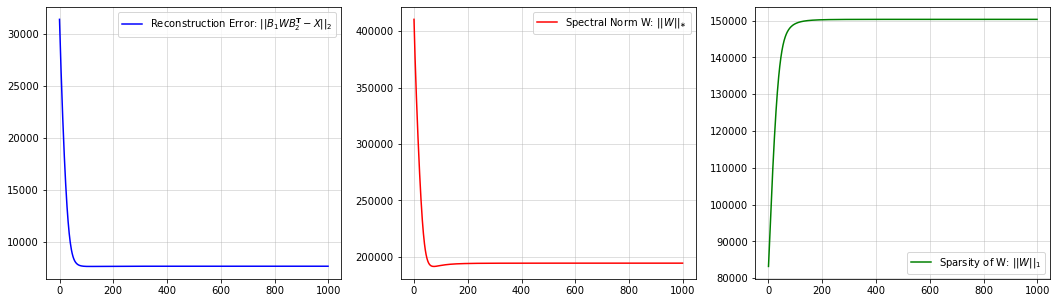

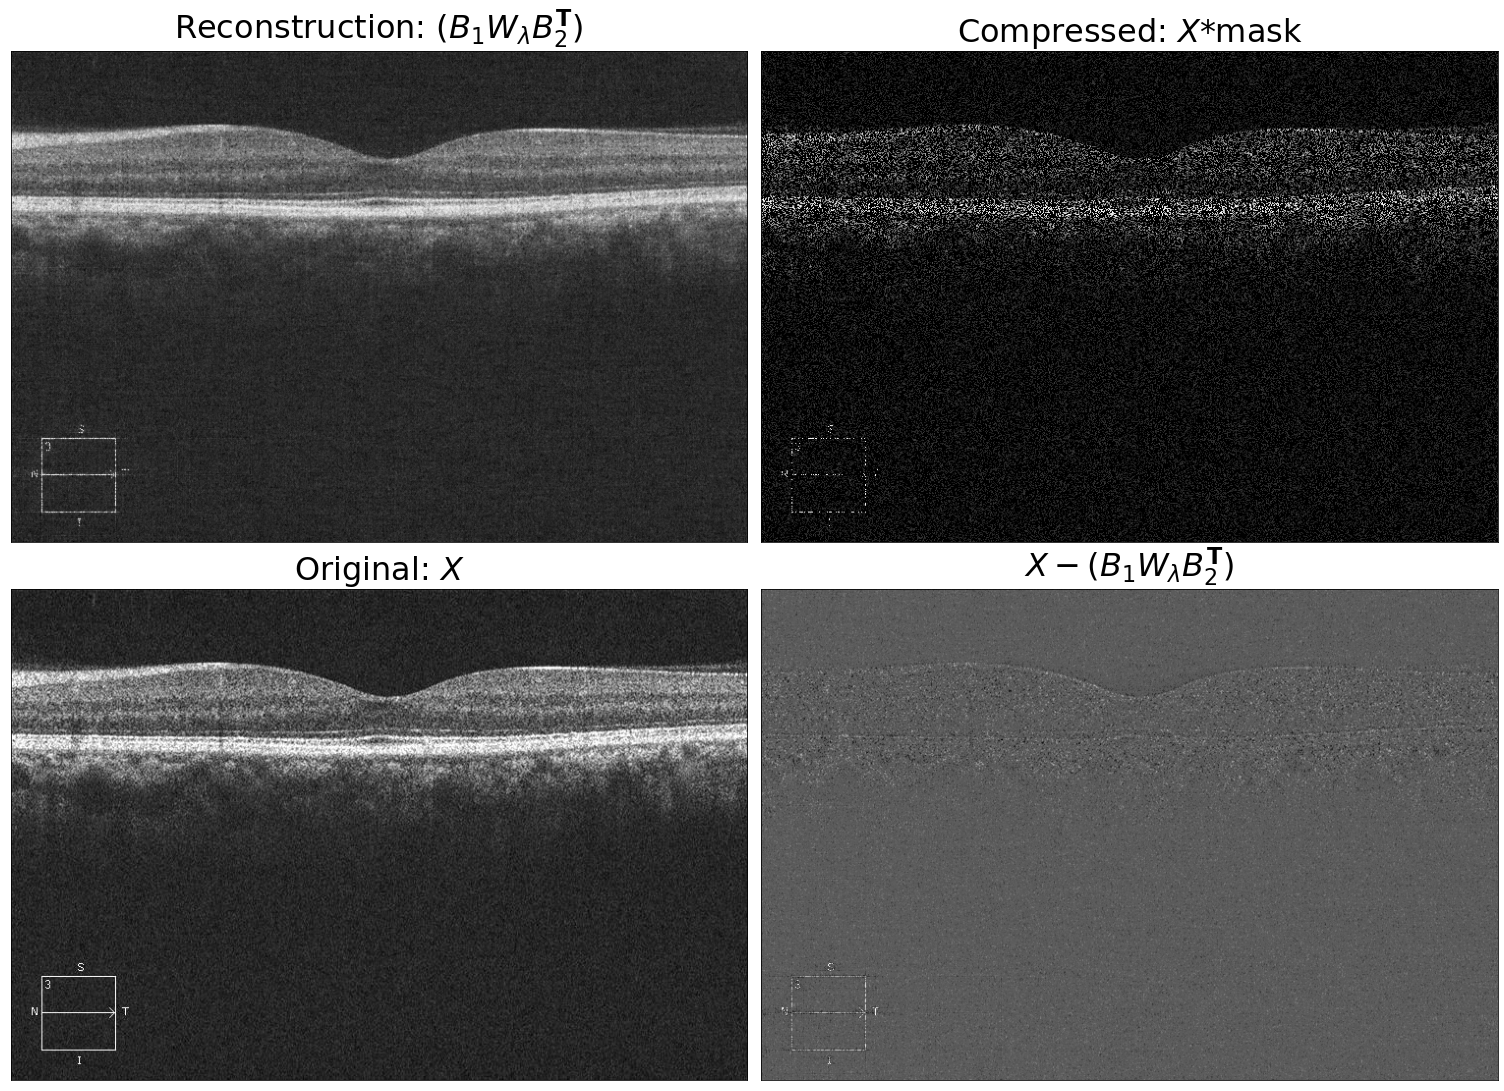

In [256]:
lbda_ = 3
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(results_sparse[lbda_]['reconstruction'], c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(results_sparse[lbda_]['spectral'], c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(results_sparse[lbda_]['sparsity'], c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

# fig.suptitle(f"Sparse Reconstruction using {basis_} basis " + r"($\lambda$ =" + f"{lbda_}):", fontsize=22)

fig.set_facecolor('white')
plt.savefig("Sparse_Compression_2_lambda_3_plots.png", dpi=400)

print(f"Resulting Reconstruction")
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 15.5))

W_ = results_sparse[lbda_]['W']

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[0][0].imshow(B1 @ W_ @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X*mask, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=32)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[1][1].imshow(X - (B1 @ W_ @ B2t), cmap="gray")

for ax in axes:
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=-0.1)

plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("Sparse_Compression_2_lambda_3_grid.png", dpi=400)

In [277]:
np.sum(results[30]['W']== 0), np.sum(results_sparse[3]['W'] == 0)/(w*h)

(0, 0.5942346666666667)

Resulting Reconstruction:


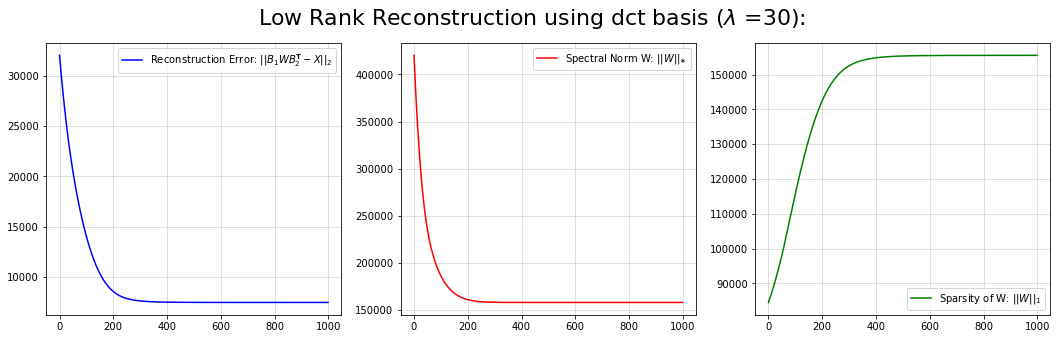

<Figure size 1008x648 with 0 Axes>

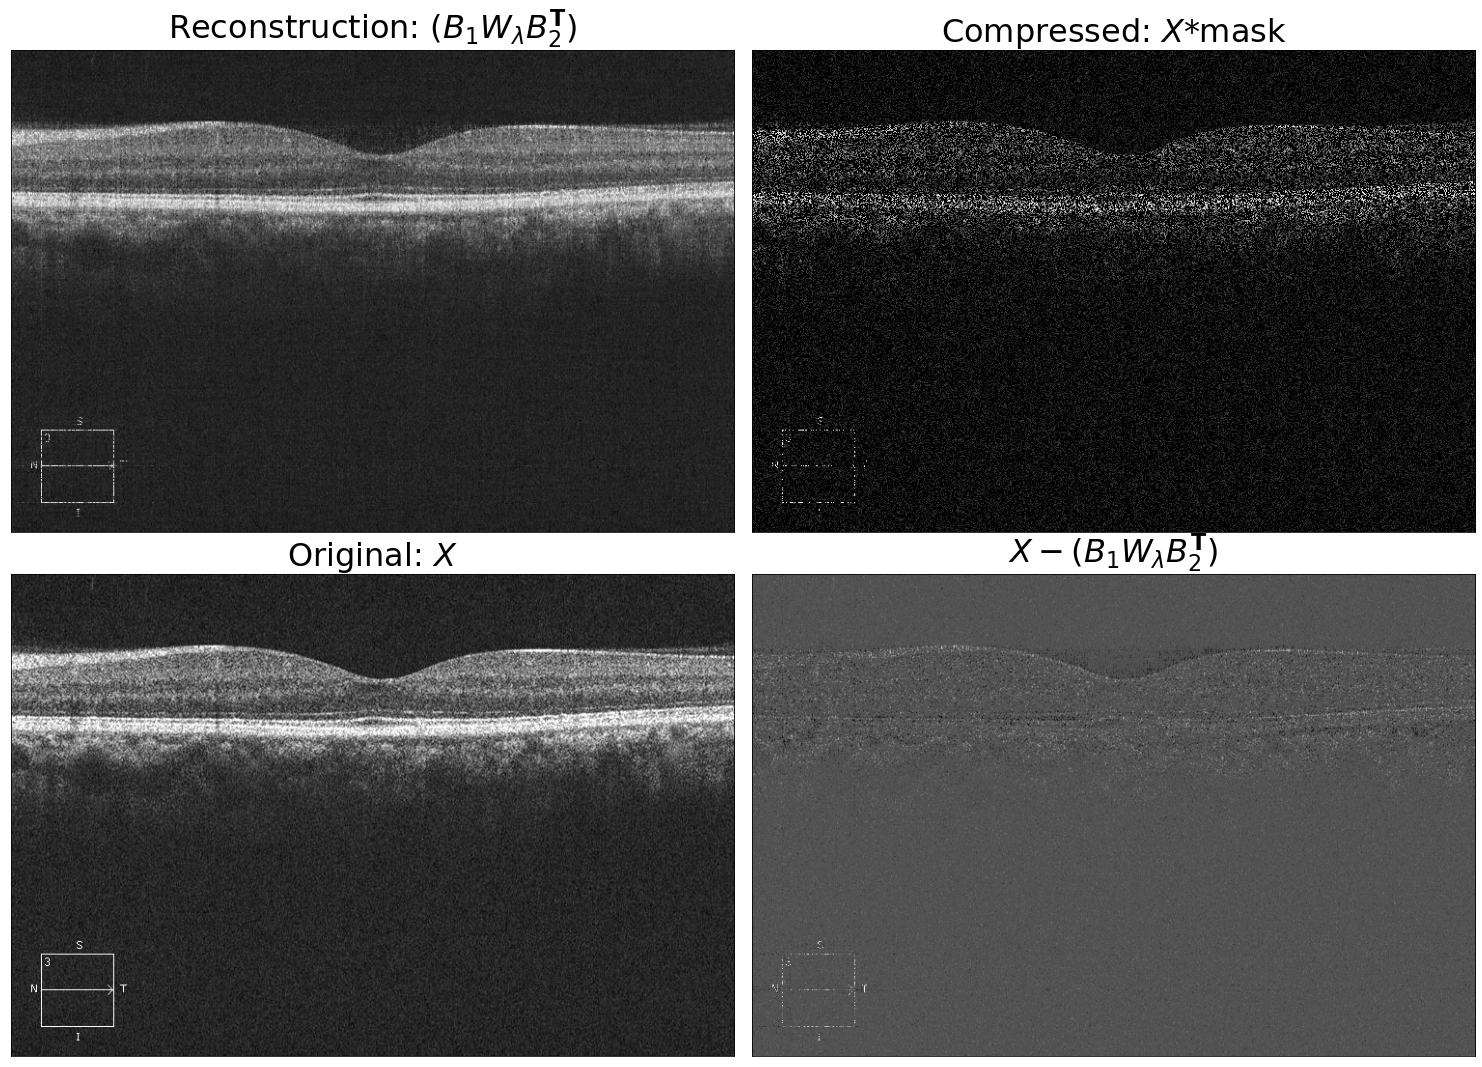

In [259]:
lbda_ = 30
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(results[lbda_]['reconstruction'], c='b', label=r"Reconstruction Error: $||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$")
axes[1].plot(results[lbda_]['spectral'], c='r', label=r"Spectral Norm W: $|| W ||_{\ast}$")
axes[2].plot(results[lbda_]['sparsity'], c='g', label=r"Sparsity of W: $|| W ||_{1}$")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.5)
axes[1].grid(alpha=0.5)
axes[2].grid(alpha=0.5)

fig.suptitle(f"Low Rank Reconstruction using {basis_} basis " + r"($\lambda$ =" + f"{lbda_}):", fontsize=22)
fig.set_facecolor('white')
plt.savefig("LowRank_Compression_2_lambda_30_plots.png", dpi=400)

print(f"Resulting Reconstruction:")
plt.figure(figsize=(14, 9));

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(21, 16))
W_ = results[lbda_]['W']

axes[0][0].set_title(r"Reconstruction: $(B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[0][0].imshow(B1 @ W_ @ B2t, cmap="gray")

axes[0][1].set_title(r"Compressed: $X$*mask", fontsize=32)
axes[0][1].imshow(X*mask, cmap="gray")

axes[1][0].set_title(r"Original: $X$", fontsize=32)
axes[1][0].imshow(X, cmap="gray")

axes[1][1].set_title(r"$X - (B_{1} W_{\lambda} B_{2}^{\mathbf{T}}$)", fontsize=32)
axes[1][1].imshow(X - (B1 @ W_ @ B2t), cmap="gray")

plt.tight_layout()
fig.set_facecolor('white')

for ax in axes:
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
fig.subplots_adjust(wspace=0.025, hspace=-0.1)

plt.savefig("LowRank_Compression_2_lambda_30_grid.png", dpi=400)
plt.show()

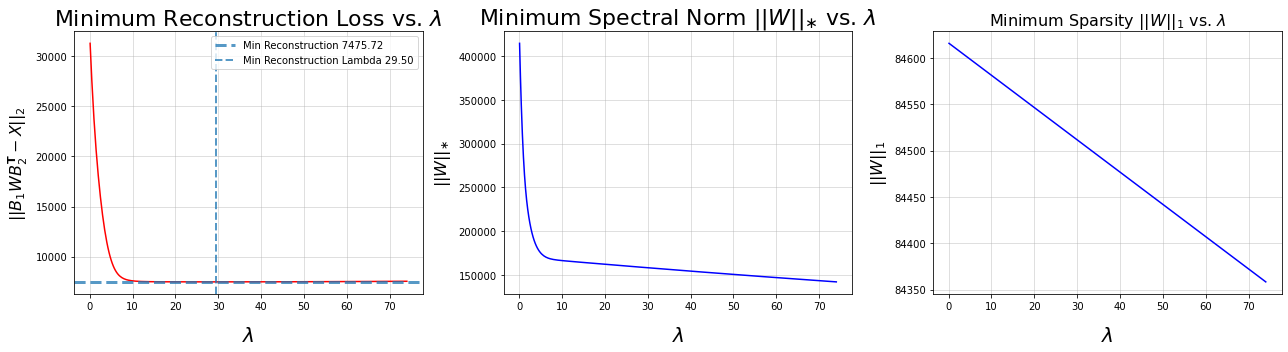

In [251]:
min_reconstruction = [min(results[l]['reconstruction']) for l in results.keys()]
final_spectral = [min(results[l]['spectral']) for l in results.keys()]
final_sparse = [min(results[l]['sparsity']) for l in results.keys()]
lambda_vals = list(results.keys())

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(list(results.keys()), min_reconstruction, c='r')
axes[0].axhline(min(min_reconstruction), label=f"Min Reconstruction {min(min_reconstruction):.2f}",ls='--', alpha=0.75, lw=3)
axes[0].axvline(
    lambda_vals[np.argmin(min_reconstruction)],
    label=f"Min Reconstruction Lambda {lambda_vals[np.argmin(min_reconstruction)]:.2f}",
    ls='--', alpha=0.75, lw=2
)
axes[0].set_title(r"Minimum Reconstruction Loss vs. $\lambda$", fontsize=22)
axes[0].set_ylabel(r"$||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$", fontsize=16, labelpad=5)
axes[0].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[0].grid(alpha=0.5)
axes[0].legend()

axes[1].plot(list(results.keys()), final_spectral, c='b')
axes[1].set_title(r"Minimum Spectral Norm $||W||_{\ast}$ vs. $\lambda$", fontsize=22)
axes[1].set_ylabel(r"$||W||_{\ast}$", fontsize=16, labelpad=5)
axes[1].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[1].grid(alpha=0.5)

axes[2].plot(list(results.keys()), final_sparse, c='b')
axes[2].set_title(r"Minimum Sparsity $||W||_{1}$ vs. $\lambda$", fontsize=16)
axes[2].set_ylabel(r"$||W||_{1}$", fontsize=16, labelpad=5)
axes[2].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[2].grid(alpha=0.5)

# fig.suptitle(r"Min Reconstruction & Spectral Norm vs. $\lambda$, Low Rank", y=1.06, fontsize=24)
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("LowRank_compression_2_hyperparam_plots.png", dpi=400)
plt.show()

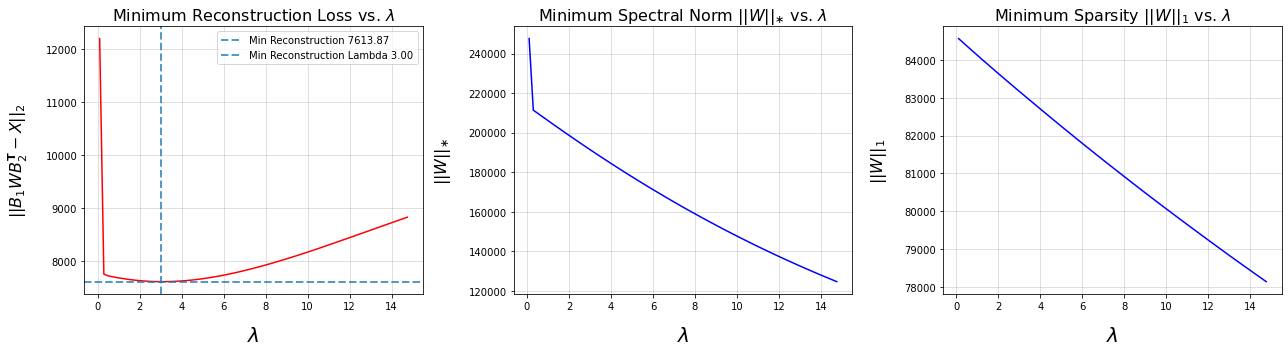

In [250]:
min_reconstruction = [min(results_sparse[l]['reconstruction']) for l in results_sparse.keys()]
final_spectral = [min(results_sparse[l]['spectral']) for l in results_sparse.keys()]
final_sparse = [min(results_sparse[l]['sparsity']) for l in results_sparse.keys()]
lambda_vals = list(results_sparse.keys())

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(list(results_sparse.keys()), min_reconstruction, c='r')
axes[0].axhline(min(min_reconstruction), label=f"Min Reconstruction {min(min_reconstruction):.2f}",ls='--', alpha=0.75, lw=2)
lambda_vals = list(results_sparse.keys())
axes[0].axvline(
    lambda_vals[np.argmin(min_reconstruction)],
    label=f"Min Reconstruction Lambda {lambda_vals[np.argmin(min_reconstruction)]:.2f}",
    ls='--', alpha=0.75, lw=2
)

axes[0].set_title(r"Minimum Reconstruction Loss vs. $\lambda$", fontsize=16)
axes[0].set_ylabel(r"$||B_{1} W B_{2}^{\mathbf{T}} - X ||_{2}$", fontsize=16, labelpad=15)
axes[0].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[0].grid(alpha=0.5)
axes[0].legend()

axes[1].plot(list(results_sparse.keys()), final_spectral, c='b')
axes[1].set_title(r"Minimum Spectral Norm $||W||_{\ast}$ vs. $\lambda$", fontsize=16)
axes[1].set_ylabel(r"$||W||_{\ast}$", fontsize=16, labelpad=15)
axes[1].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[1].grid(alpha=0.5)

axes[2].plot(list(results_sparse.keys()), final_sparse, c='b')
axes[2].set_title(r"Minimum Sparsity $||W||_{1}$ vs. $\lambda$", fontsize=16)
axes[2].set_ylabel(r"$||W||_{1}$", fontsize=16, labelpad=15)
axes[2].set_xlabel(r"$\lambda$", fontsize=20, labelpad=15)
axes[2].grid(alpha=0.5)

# fig.suptitle(r"Min Reconstruction & Sparse Norm vs. $\lambda$, Sparse", y=1.06, fontsize=24)
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig("sparse_compression_2_hyperparam_plots.png", dpi=400)
plt.show()

### Starter Code for rank/sparsity minimization

Iteration 1:	Reconstruction Error: 37303.80	Spectral Norm W: 397122.67	Sparisty of W: 59582.81
Resulting Reconstruction after 0 interations:


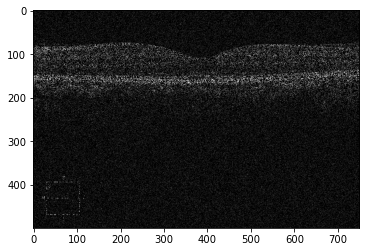

Iteration 51:	Reconstruction Error: 36481.01	Spectral Norm W: 380548.09	Sparisty of W: 60413.15
Iteration 101:	Reconstruction Error: 35687.25	Spectral Norm W: 364832.22	Sparisty of W: 61265.89
Iteration 151:	Reconstruction Error: 34921.99	Spectral Norm W: 350338.25	Sparisty of W: 62129.60
Iteration 201:	Reconstruction Error: 34183.00	Spectral Norm W: 337308.95	Sparisty of W: 63014.50
Iteration 251:	Reconstruction Error: 33467.96	Spectral Norm W: 325528.97	Sparisty of W: 63918.37
Resulting Reconstruction after 250 interations:


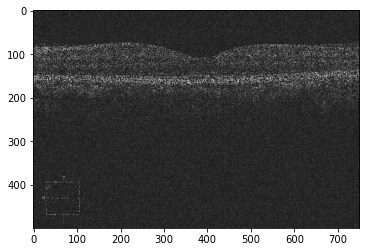

Iteration 301:	Reconstruction Error: 32775.16	Spectral Norm W: 314771.98	Sparisty of W: 64846.70
Iteration 351:	Reconstruction Error: 32103.14	Spectral Norm W: 304888.35	Sparisty of W: 65801.17
Iteration 401:	Reconstruction Error: 31450.90	Spectral Norm W: 295730.43	Sparisty of W: 66775.90
Iteration 451:	Reconstruction Error: 30817.54	Spectral Norm W: 287224.46	Sparisty of W: 67767.20
Iteration 501:	Reconstruction Error: 30202.49	Spectral Norm W: 279292.87	Sparisty of W: 68759.59
Resulting Reconstruction after 500 interations:


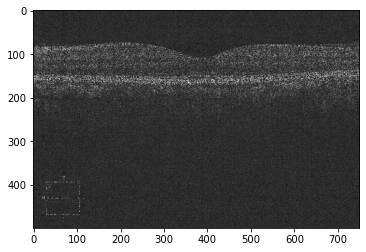

Iteration 551:	Reconstruction Error: 29605.14	Spectral Norm W: 271876.25	Sparisty of W: 69747.93
Iteration 601:	Reconstruction Error: 29024.98	Spectral Norm W: 264937.65	Sparisty of W: 70736.45
Iteration 651:	Reconstruction Error: 28461.58	Spectral Norm W: 258433.84	Sparisty of W: 71729.63
Iteration 701:	Reconstruction Error: 27914.50	Spectral Norm W: 252332.67	Sparisty of W: 72739.61
Iteration 751:	Reconstruction Error: 27383.29	Spectral Norm W: 246606.28	Sparisty of W: 73753.03
Resulting Reconstruction after 750 interations:


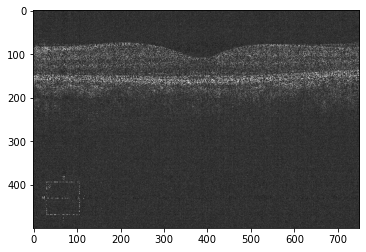

Iteration 801:	Reconstruction Error: 26867.44	Spectral Norm W: 241233.28	Sparisty of W: 74765.18
Iteration 851:	Reconstruction Error: 26366.55	Spectral Norm W: 236194.35	Sparisty of W: 75776.17
Iteration 901:	Reconstruction Error: 25880.12	Spectral Norm W: 231470.91	Sparisty of W: 76789.51
Iteration 951:	Reconstruction Error: 25407.62	Spectral Norm W: 227043.70	Sparisty of W: 77812.25


 Final Reconstruction


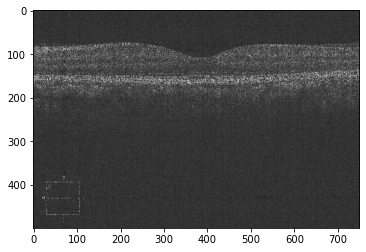

In [231]:
W_ = np.linalg.inv(B1) @ D @ np.linalg.inv(B2t)

reconstruction_error_l1 = []
spectral_norm_l1 = []
sparsity_l1 = []

iters = 1000
for i in range(iters):
    W_ = Update1(mask, B1, B2t, W_, D, 2)
    W_ = ShrinkageOperator(W_, 2)
    
    spectral_norm_l1.append(np.linalg.norm(W_, ord="nuc"))
    sparsity_l1.append(np.linalg.norm(W_, ord=1))
    reconstruction_error_l1.append(np.linalg.norm(X - B1 @ W_ @ B2t))
    if i % 50 == 0:
        print(
            f"Iteration {i+1}:\t"\
            f"Reconstruction Error: {reconstruction_error_l1[-1]:.2f}\t"\
            f"Spectral Norm W: {spectral_norm_l1[-1]:.2f}\t"\
            f"Sparisty of W: {sparsity_l1[-1]:.2f}"
        )
    if i % 250 == 0:
        print(f"Resulting Reconstruction after {i} interations:")
        plt.imshow(B1 @ W_ @ B2t, cmap="gray")
        display.display(plt.gcf())
        
print("\n\n Final Reconstruction")
plt.imshow(B1 @ W_ @ B2t, cmap="gray");

In [ ]:
import matplotlib

base = 1.001
p = 0.25
depth = 5

def rescale_cmap(name, rescale):
    cmap = plt.cm.get_cmap(name)
    colors = []
    for i in range(256):
        x = i / 256
        colors += [cmap(rescale(x))]
    return matplotlib.colors.ListedColormap(colors)


def scale(maxIdx, i):
    return np.log(i) / np.log(maxIdx)

parameter_search = np.stack([results[l]['reconstruction'] for l in results.keys()]).T

maxIdx = parameter_search.shape[1]
idx = np.unique(
    np.array(base ** np.arange(0, np.log(maxIdx) / np.log(base)), dtype=int)
)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
cmap = rescale_cmap(
    "seismic", lambda x: 0.5 * (1 - np.cos(np.pi * x ** 0.7)) / 2 + 0.5 * x
)

for i, j in enumerate(idx):
    # s = j / len(idx)
    s = scale(maxIdx, j)

    alpha = min(0.2 * np.sqrt(s) + 0.2, 1)
    if s == 1.0:
        alpha = 1.0
    ax1.plot(parameter_search[:, i], linestyle="-", color=cmap(1.0 - s), alpha=alpha)
    
    
ax1.legend(fontsize=12)
plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

# ticks = np.arange(0, max(results.keys()) + 5, 5) / max(results.keys())

cb = plt.colorbar(sm, ticks=ticks)
cb.ax.set_yticklabels(np.arange(0, max(results.keys()), 5).tolist() + [25.], fontsize=14)
cb.set_label(r"$\lambda$", fontsize=18, rotation=0, labelpad=20)